In [1]:
!pip install dicomsdl --quiet
!pip install seaborn --quiet

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import dicomsdl
from tqdm import tqdm
import gc
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import keras_cv
from sklearn.metrics import confusion_matrix

Using TensorFlow backend


In [3]:
train_csv_path = "/kaggle/input/rsna-breast-cancer-detection/train.csv"
test_csv_path = "/kaggle/input/rsna-breast-cancer-detection/test.csv"
train_image_dir = "/kaggle/input/rsna-breast-cancer-detection/train_images"
test_image_dir = "/kaggle/input/rsna-breast-cancer-detection/test_images"

In [4]:
train = pd.read_csv(train_csv_path)
train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [5]:
test = pd.read_csv(test_csv_path)
test

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


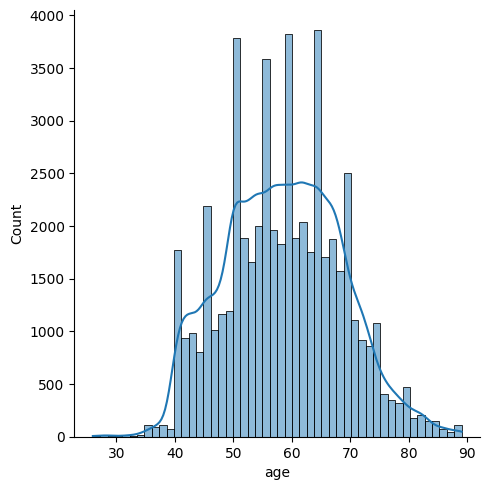

In [6]:
sns.displot(train.age, bins=50, kde=True)
plt.show()

In [7]:
diff_col = train.columns.difference(test.columns)
diff_col

Index(['BIRADS', 'biopsy', 'cancer', 'density', 'difficult_negative_case',
       'invasive'],
      dtype='object')

In [8]:
train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [9]:
images_ = train[['patient_id', 'image_id', 'cancer']]
images_['file_path'] = images_.apply(lambda x: os.path.join(train_image_dir, str(x.patient_id), str(x.image_id) + '.dcm'), axis=1)
images_

,patient_id,image_id,cancer,file_path
0,10006,462822612,0,/kaggle/input/rsna-breast-cancer-detection/tra...
1,10006,1459541791,0,/kaggle/input/rsna-breast-cancer-detection/tra...
2,10006,1864590858,0,/kaggle/input/rsna-breast-cancer-detection/tra...
3,10006,1874946579,0,/kaggle/input/rsna-breast-cancer-detection/tra...
4,10011,220375232,0,/kaggle/input/rsna-breast-cancer-detection/tra...
...,...,...,...,...
54701,9973,1729524723,0,/kaggle/input/rsna-breast-cancer-detection/tra...
54702,9989,63473691,0,/kaggle/input/rsna-breast-cancer-detection/tra...
54703,9989,1078943060,0,/kaggle/input/rsna-breast-cancer-detection/tra...
54704,9989,398038886,0,/kaggle/input/rsna-breast-cancer-detection/tra...


In [10]:
pro = images_['cancer'].value_counts().reset_index()
pro['proportion'] = pro['count'] / len(images_)
display(pro)

,cancer,count,proportion
0,0,53548,0.978832
1,1,1158,0.021168


#### As Cancer and not cancer are unbalanced interms of samples , we would have to sample data from both class so that model gets the general undrstanding of what both type of data looks like

In [11]:
not_cancer = images_[images_['cancer'] == 0]

not_cancer_sample_df = images_.sample(2000)
not_cancer_sample_df

cancer_df = images_[images_['cancer'] == 1]
images_ = pd.concat([cancer_df, not_cancer_sample_df])
images_

,patient_id,image_id,cancer,file_path
87,10130,388811999,1,/kaggle/input/rsna-breast-cancer-detection/tra...
88,10130,613462606,1,/kaggle/input/rsna-breast-cancer-detection/tra...
89,10130,1360338805,1,/kaggle/input/rsna-breast-cancer-detection/tra...
90,10130,1672636630,1,/kaggle/input/rsna-breast-cancer-detection/tra...
190,10226,461614796,1,/kaggle/input/rsna-breast-cancer-detection/tra...
...,...,...,...,...
33572,46020,1801273372,0,/kaggle/input/rsna-breast-cancer-detection/tra...
39909,53136,78315483,0,/kaggle/input/rsna-breast-cancer-detection/tra...
14063,25037,1210611129,0,/kaggle/input/rsna-breast-cancer-detection/tra...
4317,14676,252119513,0,/kaggle/input/rsna-breast-cancer-detection/tra...


# Training and validation data generator

In [12]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,   
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    horizontal_flip=True,  
    vertical_flip=True,    
    fill_mode='reflect'    
)


class BreastCancerDataset(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True, datagen=None):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.datagen = datagen
        self.indices = np.arange(len(self.df))
        
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        start = index  * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        
        # Use ProcessPoolExecutor for parallel image loading and preprocessing
        with ProcessPoolExecutor(max_workers= multiprocessing.cpu_count()) as executor:
            results = list(executor.map(self.load_and_preprocess_image, [self.df.iloc[idx]['file_path'] for idx in batch_indices]))

        X = np.array([result[0] for result in results])
        y = np.array([result[1] for result in results])
        
        return X, y.reshape(-1, 1)

    
    def load_and_preprocess_image(self, file_path):
        
        def normalize_image(image):
            min_val = np.min(image)
            max_val = np.max(image)
            image = (image - min_val) / (max_val - min_val)
            
            return image
        
        try:
            image = dicomsdl.open(file_path).pixelData()
            image = cv2.resize(image, (self.image_size[1], self.image_size[0]))
            image = np.expand_dims(image, axis=-1)
            image = normalize_image(image)
            if self.datagen:
                image = self.datagen.random_transform(image)
            label = self.df[self.df['file_path'] == file_path]['cancer'].values[0]
            return image, label
        except Exception as e:
            print(f'Error loading image from {file_path}: {str(e)}')
            return None, None




# Split the data
train_images_df, val_images_df = train_test_split(images_, test_size=0.1)

# Define batch size and target size
batch_size = 15  
image_size = (640, 512)
STEPS_PER_EPOCHS = train_images_df.shape[0] / batch_size

print("Number of Training Samples : {}".format(train_images_df.shape[0]))
print("Number of Validation Samples : {}".format(val_images_df.shape[0]))
print(f"Number of Samples in one Batch: {batch_size}")
print(f'STEPS PER EPOCHS: {STEPS_PER_EPOCHS}')

# Create data generators using tf.data
train_dataset = BreastCancerDataset(train_images_df, batch_size, image_size, datagen=datagen)
val_dataset = BreastCancerDataset(val_images_df, batch_size, image_size)


train_data_loader = tf.data.Dataset.from_generator(
    lambda: train_dataset,
    output_signature=(
        tf.TensorSpec(shape=(None, *image_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,1), dtype=tf.int32)
    )).cache().prefetch(tf.data.AUTOTUNE)

val_data_loader = tf.data.Dataset.from_generator(
    lambda: val_dataset,
    output_signature=(
        tf.TensorSpec(shape=(None, *image_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,1), dtype=tf.int32)
    )).cache().prefetch(tf.data.AUTOTUNE)

Number of Training Samples : 2842
Number of Validation Samples : 316
Number of Samples in one Batch: 15
STEPS PER EPOCHS: 189.46666666666667


## Callbacks

In [13]:
class CustomCallback(Callback):
    def __init__(self, target_accuracy=0.90):
        super(CustomCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nReached target accuracy ({self.target_accuracy}), stopping training!")
            self.model.stop_training = True

custom_callback = CustomCallback(target_accuracy=0.85)

early_stopper = EarlyStopping(monitor='accuracy',
                              min_delta= 0.01,
                              patience = 3,
                              restore_best_weights=True
                             )
#Learning Rate
class LearningRateMetric(tf.keras.metrics.Metric):
    def __init__(self, name='learning_rate', **kwargs):
        super(LearningRateMetric, self).__init__(name=name, **kwargs)
        self.learning_rates = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        self.learning_rates.append(current_lr)

    def result(self):
        return self.learning_rates

class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=1e-4, max_lr=1e-2, step_size=8, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0
        self.trn_iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)

        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x)
        elif self.mode == 'triangular2':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x) / (2 ** (cycle - 1))

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if self.clr_iterations == 0:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())
        
        
clr = CyclicLR(base_lr=1e-4, max_lr=1e-2, step_size=8, mode='triangular')

In [14]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

with strategy.scope():
    
    base_model = keras_cv.models.YOLOV8Backbone(stackwise_channels=[128, 256, 512, 1024],
                                                include_rescaling=False,
                                                stackwise_depth=[3, 9, 12, 3],
                                                input_tensor=Input(shape=(*image_size,1)))
    base_model.trainable = True
    
    model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            BatchNormalization(),
            
            Dense(1, activation='sigmoid')
        ]
    )
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'FalseNegatives'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 yolov8_backbone (YOLOV8Back  (None, 20, 16, 1024)     46403392  
 bone)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 46,408,513
Trainable params: 46,367,937
Non-trainable params: 40,576
_______________________________________

In [16]:
hist = model.fit(train_data_loader, validation_data=val_data_loader, epochs=100, callbacks=[early_stopper, clr, custom_callback])

Epoch 1/100
190/190 [==============================] - 1090s 5s/step - loss: 0.7756 - accuracy: 0.5274 - false_negatives: 622.0000 - val_loss: 0.6806 - val_accuracy: 0.6361 - val_false_negatives: 113.0000
Epoch 2/100
190/190 [==============================] - 165s 867ms/step - loss: 0.7202 - accuracy: 0.5542 - false_negatives: 774.0000 - val_loss: 0.7053 - val_accuracy: 0.4082 - val_false_negatives: 10.0000
Epoch 3/100
190/190 [==============================] - 165s 869ms/step - loss: 0.7013 - accuracy: 0.5739 - false_negatives: 836.0000 - val_loss: 0.7402 - val_accuracy: 0.6361 - val_false_negatives: 114.0000
Epoch 4/100
190/190 [==============================] - 165s 871ms/step - loss: 0.7022 - accuracy: 0.5834 - false_negatives: 852.0000 - val_loss: 0.7686 - val_accuracy: 0.6361 - val_false_negatives: 114.0000
Epoch 5/100
190/190 [==============================] - 166s 872ms/step - loss: 0.6988 - accuracy: 0.5961 - false_negatives: 868.0000 - val_loss: 0.7884 - val_accuracy: 0.5665 

In [17]:
model.save('yolo_xl.h5')

## Model Performance

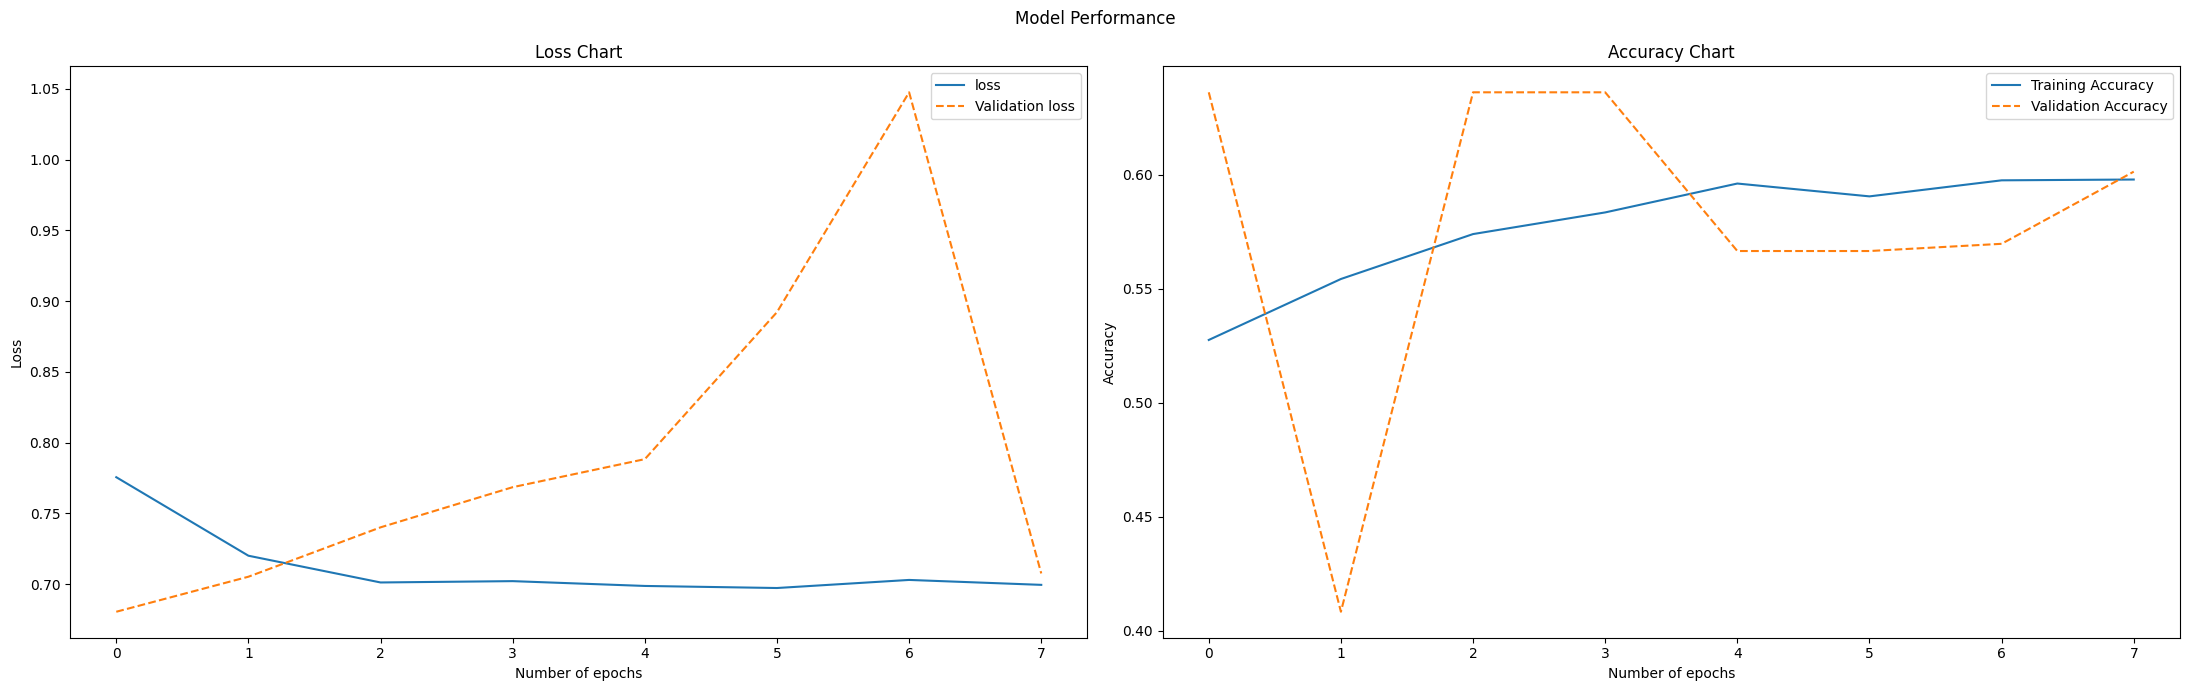

In [18]:
fig, axes = plt.subplots(ncols=2, figsize= (22,7))
sns.lineplot(hist.history['loss'], ax= axes[0], label='loss')
sns.lineplot(hist.history['val_loss'], ax=axes[0], label='Validation loss', linestyle='--')
axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Chart')

sns.lineplot(hist.history['accuracy'], ax=axes[1], label='Training Accuracy')
sns.lineplot(hist.history['val_accuracy'], ax=axes[1], label='Validation Accuracy', linestyle='--')
axes[1].set_xlabel('Number of epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Chart')

plt.suptitle('Model Performance')
plt.tight_layout()
plt.show()

## SUBMISSION

In [19]:
def submission(dataframe, image_dir, model):
    dataframe['file_path'] = dataframe.apply(lambda x: os.path.join(image_dir , str(x.patient_id), str(x.image_id)) + '.dcm', axis=1)
    dataframe['cancer'] = 0
    test_data_loader = BreastCancerDataset(dataframe,1, image_size, shuffle=False)
    
    prediction = []
    for image, label in tqdm(test_data_loader, desc='Predicting Images'):
        pred = model.predict(image, verbose=0)
        prediction.extend(pred)
        
    submit = pd.DataFrame({'prediction_id': dataframe['prediction_id'], 'cancer': prediction})
    
    submit.to_csv('submission.csv', index=False)
    return None

In [20]:
submission(test, test_image_dir, model)

Predicting Images: 100%|██████████| 4/4 [00:12<00:00,  3.04s/it]
